# Benchmark Algorithms

* Test on some existing data set
* Train as many algorithms as possible

    1. Naive Bayes
    2. Linear Classifier
    3. SVM
    2. Random Forest 
    4. Gradient Boost

In [32]:
from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.ensemble import VotingClassifier

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [33]:
# load data = modify as per need
remove = ('headers', 'footers', 'quotes')
remove = ()
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)

feature_names = None
target_names = data_train.target_names
y_train = data_train.target
y_test = data_test.target

vectorizer = TfidfVectorizer(sublinear_tf=True, use_idf=True, ngram_range=(1,3), max_df=0.5, stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)
X_test = vectorizer.transform(data_test.data)
feature_names = vectorizer.get_feature_names()

if feature_names:
    feature_names = np.asarray(feature_names)

In [29]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if feature_names is not None:
            print("top 20 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-20:]
                print("%s: %s" % (label, " ".join(feature_names[top10])))
        print()

    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=target_names))

    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [36]:
results = []
estimators = []

for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    estimators.append((name, clf))
    results.append(benchmark(clf))
    
    
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    estimators.append(('LinearSVC-'+penalty, LinearSVC(penalty=penalty, dual=False, tol=1e-3)))
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))

    # Train SGD model
    estimators.append(('SGDClassifier-'+penalty, SGDClassifier(alpha=.0001, n_iter=50, penalty=penalty)))
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50, penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
estimators.append(('SGDClassifier-elasticnet', SGDClassifier(alpha=.0001, n_iter=50, penalty="elasticnet")))
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50, penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
estimators.append(('NearestCentroid', NearestCentroid()))
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
estimators.append(('MultinomialNB',MultinomialNB(alpha=.01)))
results.append(benchmark(MultinomialNB(alpha=.01)))
estimators.append(('BernoulliNB',MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")

# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
estimators.append(('LinearSVC-L1Features',Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

results.append(benchmark(VotingClassifier(estimators=estimators,voting='hard')))


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


train time: 2.119s
test time:  0.017s
accuracy:   0.902
dimensionality: 498751
density: 1.000000
top 20 keywords per class:
alt.atheism: benedikt mathew osrhe bible religious okcforum jaeger rushdie edu keith religion atheist people caltech caltech edu islam islamic god keith atheism atheists
comp.graphics: ftp polygon animation code vga video package card color help looking hi windows format files 3d file image thanks graphics
sci.space: alaska edu lunar spacecraft alaska dc access henry flight digex access digex gov nasa gov pat shuttle sci launch moon orbit nasa space
talk.religion.misc: mitre org bible weiss beast mitre order church truth com hudson mr morality biblical fbi christ koresh christians god jesus christian

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.86      0.87      0.87       319
     comp.graphics       0.90      0.97      0.93       389
         sci.space       0.96      0.94      0.95       394
tal

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 1.282s
test time:  0.024s
accuracy:   0.888
dimensionality: 498751
density: 0.120057
top 20 keywords per class:
alt.atheism: alt atheism theists ll free claim faq guess words thing dan religious god evolution keith tells deleted islamic atheist atheism atheists
comp.graphics: double studio nl 24 thanks help library 3do windows 3d need line hi package ftp image file code animation graphics
sci.space: gamma wright power stars film phobos flight shuttle project funding things mars distribution sci astronomy moon nasa planets sci orbit space
talk.religion.misc: say christian morality distribution usa lines hare mormons distribution usa fbi christians 2000 years 2000 told hudson children abortion subject 2000 years subject 2000 beast biblical years jesus christian

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.86      0.85      0.85       319
     comp.graphics       0.92      0.93      0.93       389
         sci.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 1.435s
test time:  0.020s
accuracy:   0.907
dimensionality: 498751
density: 0.809467
top 20 keywords per class:
alt.atheism: benedikt osrhe bible caltech edu keith people religious okcforum jaeger rushdie religion edu keith atheist caltech caltech edu islam islamic god keith atheism atheists
comp.graphics: advance video animation code looking color package vga computer card windows help hi format files 3d file thanks image graphics
sci.space: billion access henry lunar alaska edu digex access digex nasa gov flight alaska dc spacecraft pat shuttle sci launch moon orbit nasa space
talk.religion.misc: distribution usa lines order mormons 2000 years subject 2000 years subject 2000 mitre org hudson mitre beast mr biblical morality god christ fbi christians koresh jesus christian

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.88      0.86      0.87       319
     comp.graphics       0.91      0.97      0.94       38

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 1.401s
test time:  0.022s
accuracy:   0.911
dimensionality: 498751
density: 0.808351
top 20 keywords per class:
alt.atheism: genocide osrhe jaeger okcforum mathew edu keith rushdie bible religious caltech people islam caltech edu religion atheist islamic god keith atheists atheism
comp.graphics: computer vga email code package video help color animation windows looking card hi format files 3d file thanks image graphics
sci.space: planets access earth lunar digex access digex alaska solar nasa gov spacecraft flight pat dc shuttle sci launch moon orbit nasa space
talk.religion.misc: 2000 church 666 truth order 2000 years subject 2000 subject 2000 years hudson christ beast mr biblical morality fbi christians koresh god jesus christian

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.88      0.87      0.88       319
     comp.graphics       0.91      0.97      0.94       389
         sci.space       0.96      0.95  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 3.861s
test time:  0.020s
accuracy:   0.888
dimensionality: 498751
density: 0.001657
top 20 keywords per class:
alt.atheism: islam liar okcforum benedikt psilink rice perry lunatic genocide bobby evolution charley freedom wingate rushdie atheist keith islamic atheism atheists
comp.graphics: tiff thanks pov color code vga windows 3do sphere looking files video card points animation hi 3d file image graphics
sci.space: sky pat sci rocket funding mars solar spacecraft orbital lunar astronomy shuttle rockets dc flight nasa launch moon orbit space
talk.religion.misc: davidians mitre truth order tyre koresh church distribution usa lines homosexuality jesus abortion mr christians 666 christ hudson biblical fbi beast christian

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.86      0.77      0.82       319
     comp.graphics       0.94      0.97      0.95       389
         sci.space       0.94      0.95      0.95     

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 4.017s
test time:  0.022s
accuracy:   0.905
dimensionality: 498751
density: 0.072119
top 20 keywords per class:
alt.atheism: caltech edu islam alt bible wingate edu keith evolution charley genocide claim religion rushdie alt atheism religious god keith atheist islamic atheists atheism
comp.graphics: windows help color email package points code looking files animation card computer video format hi 3d thanks file image graphics
sci.space: billion subject space cost planets orbital rockets pat solar spacecraft lunar astronomy flight sci dc shuttle launch moon orbit nasa space
talk.religion.misc: homosexuality weiss god distribution usa lines order 666 lord mormons hudson morality church biblical koresh christ christians mr beast fbi jesus christian

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.87      0.86      0.86       319
     comp.graphics       0.92      0.97      0.95       389
         sci.space       0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\ProgramData\A

train time: 41.493s
test time:  1.089s
accuracy:   0.908
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.87      0.88      0.87       319
     comp.graphics       0.91      0.98      0.94       389
         sci.space       0.96      0.95      0.95       394
talk.religion.misc       0.88      0.77      0.82       251

       avg / total       0.91      0.91      0.91      1353

confusion matrix:
[[281   6   7  25]
 [  2 381   4   2]
 [  0  21 373   0]
 [ 41  11   5 194]]



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


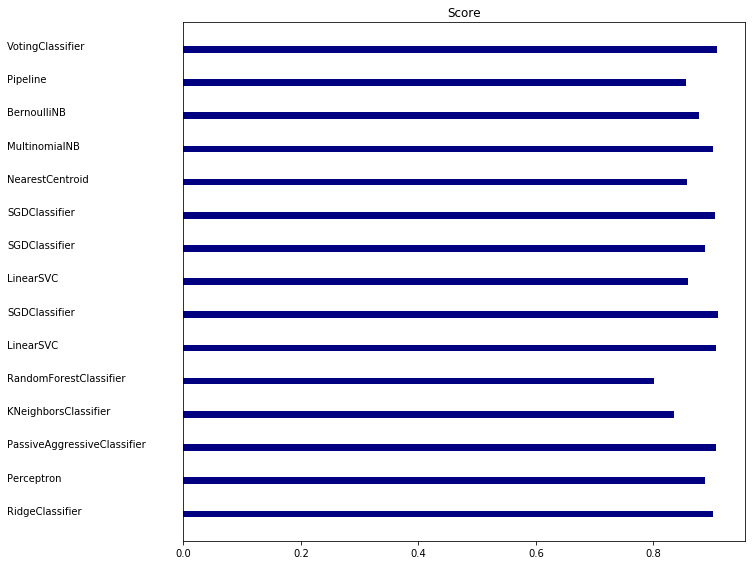

In [38]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
#plt.barh(indices + .3, training_time, .2, label="training time", color='c')
#plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
#plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()